In [1]:
import os, json
import torch


dir = '/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results'

In [ ]:
for file in os.listdir(dir):
    if file.endswith('.json'):
        path = os.path.join(dir, file)
        try:
            with open(path, 'r') as f:
                data = json.load(f)
            if not isinstance(data, dict) or not data:  # Leer oder kein Dict
                print("⚠️ Leer/unklar:", file)
        except Exception as e:
            print("❌ Fehler in", file, "->", e)

        
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.ckpt'):
            path = os.path.join(root, file)
            try:
                ckpt = torch.load(path, map_location='cpu')
            except Exception as e:
                print("❌ Fehlerhafter Checkpoint:", path, "->", e)


In [ ]:
from ray.tune import ExperimentAnalysis

exp_dir = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/"
analysis = ExperimentAnalysis(exp_dir)
for trial in analysis.trials:
    res = trial.last_result if hasattr(trial, "last_result") else {}
    if "silhouette" not in res:
        print(f"⚠️ Trial {trial.trial_id} fehlt silhouette!")


In [ ]:
import json

path = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/vae_gmm_scan_v56/experiment_state-2025-06-27_12-05-50.json"
with open(path, "r") as f:
    state = json.load(f)

# Entferne alle Einträge mit trial_id d1b489d4
state["trials"] = [t for t in state.get("trials", []) if t.get("trial_id") != ""]

with open(path, "w") as f:
    json.dump(state, f, indent=2)


import json

path = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/vae_gmm_scan_v56/search_gen_state-2025-06-27_12-05-50.json"
with open(path, "r") as f:
    gen = json.load(f)

# Falls trial_ids darin auftauchen, ebenfalls filtern
gen["generated"] = [g for g in gen.get("generated", []) if g.get("trial_id") != ""]

with open(path, "w") as f:
    json.dump(gen, f, indent=2)



Höchster Silhouette-Score: 0.12375909835100174


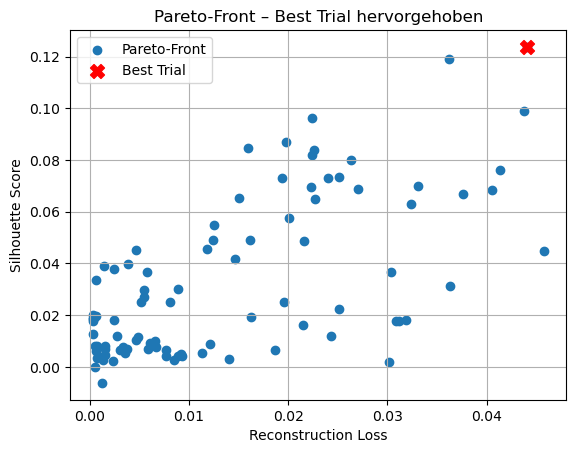

<Figure size 640x480 with 0 Axes>

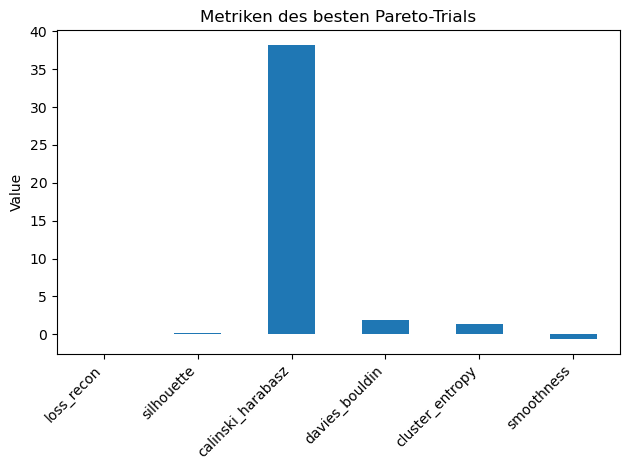

,Config Value
vae_lr,0.000988
clustering_lr,0.000028
recon_weight,0.197595
kld_weight,0.000044
gmm_end_value,0.007606
reg_end_value,0.119196
cat_end_value,0.002806
vae_lr_factor,0.758347
vae_lr_patience,30.000000
latent_dim,14.000000


In [2]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Pfade anpassen nach deinem Setup
metrics_dir = Path("/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results")

#ids_metrics = [tf.stem.split("trial_")[1] for tf in metrics_dir.glob("trial_*.json")]

# %% Zell 3: Metrics-Dateien einlesen und mit Config koppeln
pareto = []
for tf in metrics_dir.glob("trial_*.json"):
    trial = json.loads(tf.read_text(encoding="utf-8"))
    config = trial['config']
    trial_id = trial['trial_id']
    metrics = trial['metrics']

    pareto.append({
        "trial_id": trial_id,
        "config": config,
        "metrics": metrics
    })


# %% Zell 4: DataFrame bauen und filtern
df = pd.DataFrame([
    { **t["config"], **t["metrics"] }
    for t in pareto
])


df_clean = df[(df["silhouette"] > -999) & (df["loss_recon"] < 999)]

df_clean.head()


# %% Zell 5: Best Trial nach Silhouette finden
best = max(pareto, key=lambda t: t["metrics"]["silhouette"])
best_metrics = best["metrics"]
print("Höchster Silhouette-Score:", best_metrics["silhouette"])


# %% Zell 6: Pareto-Front Scatter-Plot
plt.figure()
plt.scatter(
    df_clean['loss_recon'], df_clean['silhouette'],
    label='Pareto-Front'
)
plt.scatter(
    best_metrics['loss_recon'], best_metrics['silhouette'],
    marker='X', s=100, c='red', label='Best Trial'
)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Silhouette Score")
plt.title("Pareto-Front – Best Trial hervorgehoben")
plt.legend()
plt.grid(True)
plt.show()


# %% Zell 7: Bar-Chart der Metriken des besten Trials
metrics_df = pd.DataFrame.from_dict(
    best_metrics, orient='index', columns=['Value']
)

plt.figure()
metrics_df.plot(kind='bar', legend=False)
plt.title("Metriken des besten Pareto-Trials")
plt.ylabel("Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% Zell 8: Konfig-DataFrame des besten Trials anzeigen
config_df = pd.DataFrame.from_dict(
    best["config"], orient='index', columns=['Config Value']
)
config_df


In [3]:
# %% Zell 1: Imports und Pfade
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ordner mit deinen trial_*.json
metrics_dir = Path("/work/aa0238/a271125/logs_ray/"
                   "vae_gmm_multi_objective_scan/version_56/interim_results")

# Wurzel, unter der alle experiment_state-*.json liegen
logs_root = Path("/work/aa0238/a271125/logs_ray/"
                 "vae_gmm_multi_objective_scan/version_56")


In [4]:
# %% Zell 2: Debug – Verzeichnis prüfen
print("metrics_dir =", metrics_dir)
print("  exists?   ", metrics_dir.exists())
print("  is_dir?   ", metrics_dir.is_dir())
print("  Dateien:  ", sorted([p.name for p in metrics_dir.glob("trial_*.json")]))


metrics_dir = /work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_56/interim_results
  exists?    True
  is_dir?    True
  Dateien:   ['trial_027027bb.json', 'trial_02f58c1c.json', 'trial_04df2370.json', 'trial_0a0aae77.json', 'trial_0b8306c1.json', 'trial_0b98b3f7.json', 'trial_0e2ea927.json', 'trial_11e02660.json', 'trial_13b907a1.json', 'trial_155ce073.json', 'trial_15c69953.json', 'trial_15e253a0.json', 'trial_16f6aafc.json', 'trial_19e203f3.json', 'trial_1a93ef87.json', 'trial_21a85fad.json', 'trial_21d205e5.json', 'trial_21d4f1d8.json', 'trial_2607bd2d.json', 'trial_268e7e98.json', 'trial_329edf50.json', 'trial_34b964d1.json', 'trial_37a54afa.json', 'trial_3e313644.json', 'trial_405a6e02.json', 'trial_42ed6b59.json', 'trial_46766ccd.json', 'trial_4de95198.json', 'trial_504a0552.json', 'trial_504ca901.json', 'trial_511714aa.json', 'trial_5944feae.json', 'trial_620ed502.json', 'trial_62771851.json', 'trial_63520691.json', 'trial_642626f2.json', 'trial_6543e26f.json',

In [5]:
# %% Zell 3: Alle Metrik-JSONs laden
trials = []
for p in metrics_dir.glob("trial_*.json"):
    tid = p.stem.split("trial_")[1]
    data = json.loads(p.read_text(encoding="utf-8"))
    trials.append({"trial_id": tid, **data})

print(f"Anzahl geladener Trials: {len(trials)}")


Anzahl geladener Trials: 92


In [6]:
df_clean

# Baue Kosten-Matrix: jede Zeile ein Trial, jede Spalte ein Ziel
cost_matrix = np.vstack([
    df_clean["loss_recon"].to_numpy(),
    -df_clean["silhouette"].to_numpy(),
    df_clean["davies_bouldin"].to_numpy(),
    -df_clean["calinski_harabasz"].to_numpy(),
    -df_clean["smoothness"].to_numpy(),
]).T

# Pareto‐Front berechnen
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # Finde alle j, die von i dominiert werden
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

pareto_df = df_clean[is_pareto]
pareto_df

,vae_lr,clustering_lr,recon_weight,kld_weight,gmm_end_value,reg_end_value,cat_end_value,vae_lr_factor,vae_lr_patience,latent_dim,gmm_epochs,warmup_epochs,adapt_epochs,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness
5,0.000031,0.000071,0.128498,0.000145,0.006853,0.291922,0.014662,0.727556,40,70,50,15,10,0.031153,0.017658,7.939654,5.576970,1.566781,-0.661749
8,0.000250,0.000031,0.150881,0.001950,0.009303,0.061460,0.011819,0.729276,30,40,80,25,15,0.036330,0.031233,12.350500,4.036983,1.601237,-0.650097
14,0.000322,0.000012,0.135660,0.000144,0.006844,0.442913,0.014755,0.751719,40,70,100,20,10,0.031866,0.018137,7.024074,5.113602,1.602552,-0.670937
17,0.004210,0.000001,0.116003,0.000644,0.008454,0.078695,0.001837,0.703028,20,60,50,20,15,0.030170,0.002061,6.591897,5.290149,1.137970,-0.673603
26,0.000809,0.000040,0.031565,0.003579,0.004831,0.179068,0.003985,0.949887,20,60,100,20,20,0.009277,0.004095,3.828944,6.580052,1.609254,-0.671349
29,0.000083,0.000040,0.069358,0.001023,0.006866,0.494859,0.040323,0.948827,10,50,50,20,15,0.018627,0.006524,5.923944,6.988860,1.559650,-0.667188
51,0.000043,0.000008,0.001928,0.000019,0.008252,0.100340,0.003057,0.772059,10,50,100,25,10,0.000567,0.000088,3.609516,6.889266,1.501285,-0.680162
53,0.000222,0.000008,0.003962,0.002387,0.009492,0.274279,0.002220,0.787173,40,60,150,15,20,0.001165,0.003977,3.763393,6.651401,1.609039,-0.673952
60,0.000027,0.000005,0.004246,0.000018,0.008360,0.020174,0.003473,0.768660,10,30,100,25,10,0.001248,-0.006220,4.741165,5.808431,1.425683,-0.661963
63,0.000044,0.000010,0.051727,0.000231,0.009501,0.176700,0.011853,0.815669,20,70,80,30,20,0.014077,0.002922,3.989362,7.615615,1.506749,-0.679744


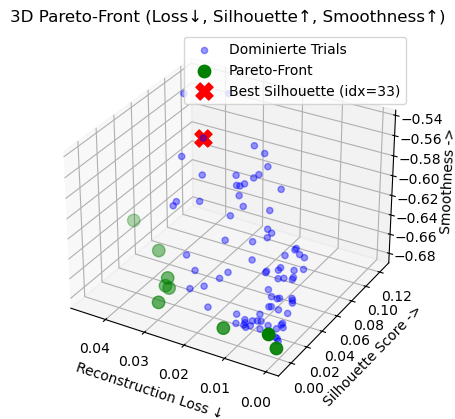

In [7]:
# %% Zell: Pareto‐Front und 3D‐Scatter für drei Ziele

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Annahme: df_clean enthält die Spalten 'loss_recon', 'silhouette', 'smoothness'
loss = df_clean["loss_recon"].to_numpy()
sil  = df_clean["silhouette"].to_numpy()
sm   = df_clean["smoothness"].to_numpy()

# 1) Kosten‐Matrix: wir wollen alles minimieren → für Max-Ziele nehmen wir das Negative
cost_matrix = np.vstack([
    loss,        # minimieren
    -sil,        # maximieren → minimiere -silhouette
    -sm,         # maximieren → minimiere -smoothness
]).T  # shape (n_trials, 3)

# 2) Pareto‐Front berechnen (Non‐Domination)
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # dominated: alle j für die cost_matrix[j] <= c in allen Zielen
    # und < c in mindestens einem
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

# 3) 3D‐Scatter zeichnen
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# (a) dominierte Trials in hellgrau
ax.scatter(
    loss[~is_pareto],
    sil[~is_pareto],
    sm[~is_pareto],
    color="blue",
    alpha=0.4,
    label="Dominierte Trials"
)

# (b) Pareto‐Front in grün
ax.scatter(
    loss[is_pareto],
    sil[is_pareto],
    sm[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# (c) Best‐Silhouette als rotes Kreuz
best_idx = sil.argmax()
ax.scatter(
    loss[best_idx],
    sil[best_idx],
    sm[best_idx],
    color="red",
    marker="X",
    s=150,
    label=f"Best Silhouette (idx={best_idx})"
)

# Labels und Titel
ax.set_xlabel("Reconstruction Loss ↓")
ax.set_ylabel("Silhouette Score ->")
ax.set_zlabel("Smoothness ->")
ax.set_title("3D Pareto‐Front (Loss↓, Silhouette↑, Smoothness↑)")

# Optional: X‐Achse invertieren, damit links kleinste Loss ist
ax.invert_xaxis()

ax.legend()
plt.show()


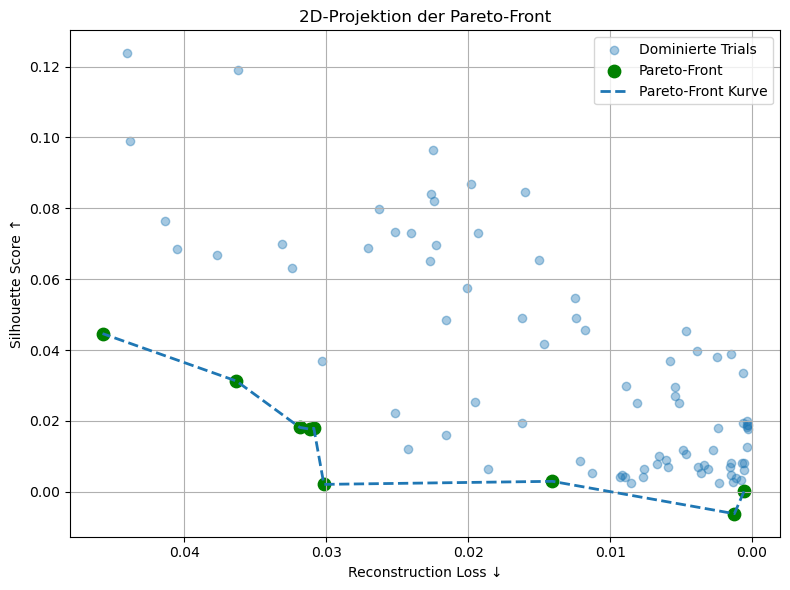

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Aus deinen vorhandenen Arrays:
# loss, sil, sm  (shape jeweils (n_trials,))
# is_pareto      (Boolean‐Array der Länge n_trials)

# 1) Wähle zwei Ziele für die 2D‐Visualisierung:
x = loss           # Reconstruction Loss (→ minimieren)
y = sil            # Silhouette Score (→ maximieren)

# 2) Scatterplot
plt.figure(figsize=(8, 6))

# a) Dominierte Trials
plt.scatter(
    x[~is_pareto],
    y[~is_pareto],
    alpha=0.4,
    label="Dominierte Trials"
)

# b) Pareto‐Front
plt.scatter(
    x[is_pareto],
    y[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# 3) (Optional) Linie durch die Pareto‐Punkte
#    Sortiere erst nach x, damit die Linie nicht kreuzt
pareto_pts = np.vstack([x[is_pareto], y[is_pareto]]).T
pareto_sorted = pareto_pts[np.argsort(pareto_pts[:, 0])]
plt.plot(
    pareto_sorted[:, 0],
    pareto_sorted[:, 1],
    linestyle="--",
    linewidth=2,
    label="Pareto‐Front Kurve"
)

# 4) Achsen beschriften und invertieren (falls gewünscht)
plt.xlabel("Reconstruction Loss ↓")
plt.ylabel("Silhouette Score ↑")
plt.title("2D‐Projektion der Pareto‐Front")
plt.gca().invert_xaxis()   # damit links kleiner ist
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
